Found 3678 images belonging to 102 classes.
Found 426 images belonging to 102 classes.
Training data shape: (64, 32, 32, 3)
Testing data shape: (64, 32, 32, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

🔹 Initial training on frozen layers...
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0469 - loss: 4.7289 - val_accuracy: 0.0000e+00 - val_loss: 4.6168
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.0156 - loss: 4.5870 - val_accuracy: 0.0312 - val_loss: 4.5334
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0312 - loss: 4.4548 - val_accuracy: 0.0312 - val_loss: 4.4552

🔹 Fine-tuning last 20 layers...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0781 - loss: 4.2584 - val_accuracy: 0.0469 - val_loss: 4.4398
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.1094 - loss: 4.1230 - val_accuracy: 0.0469 - val_loss: 4.4257
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - accuracy: 0.0938 - loss: 4.0506 - val_acc

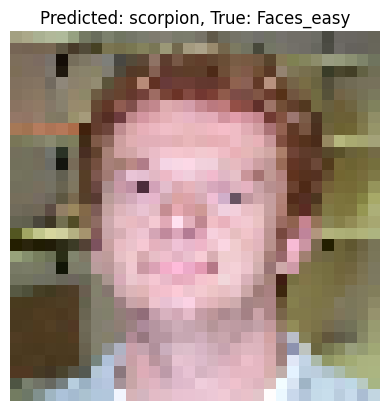

In [1]:
# a. Load a pre-trained CNN model 📸
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1️⃣ Data Preparation
# ============================
train_dir = 'dataset/train'
test_dir  = 'dataset/test'

img_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = img_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

test_gen = img_gen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

x_train, y_train = train_gen[0]
x_test, y_test = test_gen[0]

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)

# ============================
# 2️⃣ Load Pre-trained Model
# ============================
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze all layers initially
base_model.trainable = False

# ============================
# 3️⃣ Build the Full Model
# ============================
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

# Compile before initial training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Initial training on frozen layers
print("\n🔹 Initial training on frozen layers...")
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_test, y_test))

# ============================
# 4️⃣ Fine-Tuning (Unfreeze some layers)
# ============================
print("\n🔹 Fine-tuning last 20 layers...")
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test)
)

# ============================
# 5️⃣ Evaluate Model
# ============================
loss, acc = model.evaluate(test_gen)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# ============================
# 6️⃣ Predictions & Visualization
# ============================
pred = model.predict(test_gen)
labels = list(test_gen.class_indices.keys())

img_batch, true_labels = next(test_gen)
pred_labels = np.argmax(pred[:len(img_batch)], axis=1)
true_class = np.argmax(true_labels[:len(img_batch)], axis=1)

plt.imshow(img_batch[10])
plt.title(f"Predicted: {labels[pred_labels[10]]}, True: {labels[true_class[10]]}")
plt.axis('off')
plt.show()
